In [1]:
import random
import math
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import beta
from IPython.display import Image
import seaborn as sns

random.seed(4014)

## Data

In [3]:
movies = pd.read_csv('../data/movies.dat', sep='::', header=None, names=['movie_id', 'title', 'genres'], encoding='ISO-8859-1')
ratings = pd.read_csv('../data/ratings.dat', sep='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'], encoding='ISO-8859-1')
users = pd.read_csv('../data/users.dat', sep='::', header=None, names=['user_id', 'gender', 'age', 'occupation', 'zip_code'], encoding='ISO-8859-1')

<ipython-input-3-0b385b523a27>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_csv('../data/movies.dat', sep='::', header=None, names=['movie_id', 'title', 'genres'], encoding='ISO-8859-1')
<ipython-input-3-0b385b523a27>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv('../data/ratings.dat', sep='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'], encoding='ISO-8859-1')
<ipython-input-3-0b385b523a27>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different 

In [4]:
ratings["like"] = (ratings["rating"] >= 4).astype(int)

df_by_count = ratings.groupby("movie_id").agg(count=("rating", pd.Series.count), 
                                       mean=("rating", pd.Series.mean), 
                                       like_count=("like",pd.Series.sum)).sort_values(by="count", ascending=False)
df_by_count["like_prob"] = df_by_count["like_count"] / df_by_count["count"]
df_by_count.head()

,count,mean,like_count,like_prob
movie_id,,,,
2858,3428,4.317386,2853,0.832264
260,2991,4.453694,2622,0.876630
1196,2990,4.292977,2510,0.839465
1210,2883,4.022893,2127,0.737773
480,2672,3.763847,1730,0.647455


## Define Algorithms

In [5]:
class BernoulliArm():
    def __init__(self, p):
        self.p = p
    
    def draw(self):
        if random.random() > self.p:
            return 0.0
        else:
            return 1.0

### Epsilon Decay

In [6]:
class EpsilonDecay():
    
    def __init__(self, counts, values):
        self.counts = counts
        self.values = values
        return
    
    def initialize(self, n_arms):
        self.counts = [0 for item in range(n_arms)]
        self.values = [0.0 for item in range(n_arms)]
        return
        
    def select_arm(self):
        if random.random()>1/(sum(self.counts)/len(self.counts)+1): #exploit
            m = max(self.values)
            return self.values.index(m)
        else:
            return random.randrange(len(self.values))
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm] 
        value = self.values[chosen_arm]
        new_value = ((n-1)/float(n))*value+(1/float(n))*reward
        self.values[chosen_arm] = new_value
        return

### Annealing Softmax

In [7]:
class AnnealingSoftmax():
    
    def __init__(self,counts, values):
        self.counts = counts
        self.values = values
        return
    
    def initialize(self, n_arms):
        self.counts = [0 for item in range(n_arms)]
        self.values = [0.0 for item in range(n_arms)]
        return
        
    def select_arm(self):
        temperature = 1/(1+math.log(sum(self.counts)+0.000001))
        z=sum([math.exp(v/temperature) for v in self.values])
        probs=[math.exp(v/temperature)/z for v in self.values]
        current_choice = np.random.choice(n_arms, p=probs)
        return current_choice
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm] 
        value = self.values[chosen_arm]
        new_value = ((n-1)/float(n))*value+(1/float(n))*reward
        self.values[chosen_arm] = new_value
        return

### UCB 1

In [8]:
class UCB1():
    
    def __init__(self, counts, values):
        self.counts = counts
        self.values = values
        return
    
    def initialize(self, n_arms):
        self.counts = [0 for item in range(n_arms)]
        self.values = [0.0 for item in range(n_arms)]
        return
        
    def select_arm(self):
        n_arms = len(self.counts)
        for arm in range(n_arms):
            if self.counts[arm]==0:
                return arm
        
        ucb_values = [0.0 for arm in range(n_arms)]
        total_counts=sum(self.counts)
        for arm in range(n_arms):
            bonus = math.sqrt((2*math.log(total_counts))/(float(self.counts[arm])))
            ucb_values[arm] = self.values[arm] + bonus                        
        
        return ucb_values.index(max(ucb_values))
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm] 
        value = self.values[chosen_arm]
        new_value = ((n-1)/float(n))*value+(1/float(n))*reward
        self.values[chosen_arm] = new_value
        return

### Bayesian UCB

In [9]:
class BayesUCB():
    
    def __init__(self,counts,values,stdnum=3,init_alpha=1,init_beta=1):
        self.counts = counts
        self.values = values
        self.stdnum = stdnum
        self.init_alpha = init_alpha
        self.init_beta = init_beta
        self.alphas = []
        self.betas = []
        return
    
    def initialize(self, n_arms):
        self.counts = [0 for item in range(n_arms)]
        self.values = [0.0 for item in range(n_arms)]
        self.alphas = [self.init_alpha]*n_arms
        self.betas = [self.init_beta]*n_arms
        return
        
    def select_arm(self):
        best_arm = max(
            range(len(self.counts)),
            key=lambda x: self.alphas[x] / float(self.alphas[x] + self.betas[x]) + beta.std(
                self.alphas[x], self.betas[x]) * self.stdnum
        )                      
        return best_arm
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm] 
        value = self.values[chosen_arm]
        new_value = ((n-1)/float(n))*value+(1/float(n))*reward
        self.values[chosen_arm] = new_value
        # update alphas and betas
        self.alphas[chosen_arm] += reward
        self.betas[chosen_arm] += (1-reward)
        return

### Thompson Sampling

In [10]:
class ThompsonSampling():
    
    def __init__(self,counts,values,init_alpha=1,init_beta=1):
        self.counts = counts
        self.values = values
        self.init_alpha = init_alpha
        self.init_beta = init_beta
        self.alphas = []
        self.betas = []
        return
    
    def initialize(self, n_arms):
        self.counts = [0 for item in range(n_arms)]
        self.values = [0.0 for item in range(n_arms)]
        self.alphas = [self.init_alpha]*n_arms
        self.betas = [self.init_beta]*n_arms
        return
        
    def select_arm(self):
        best_arm = max(
            range(len(self.counts)),
            key=lambda x: np.random.beta(self.alphas[x],self.betas[x])
        )  
        return best_arm
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm] 
        value = self.values[chosen_arm]
        new_value = ((n-1)/float(n))*value+(1/float(n))*reward
        self.values[chosen_arm] = new_value
        # update alphas and betas
        self.alphas[chosen_arm] += reward
        self.betas[chosen_arm] += (1-reward)
        return

### Test Algorithm Function

In [11]:
def test_algorithm (algo, arms, num_sims, horizon):
    chosen_arms = [0.0 for i in range(num_sims * horizon)]
    rewards = [0.0 for i in range(num_sims * horizon)]
    cumulative_rewards = [0.0 for i in range(num_sims * horizon)]
    sim_nums = [0.0 for i in range(num_sims * horizon)]
    times = [0.0 for i in range(num_sims * horizon)]
    
    for sim in range(num_sims):
        sim = sim + 1
        algo.initialize (len(arms))
        
        for t in range(horizon):
            t = t + 1
            index = (sim - 1) * horizon + t -1 
            sim_nums[index] = sim
            times[index] = t
            
            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm
            
            reward = arms[chosen_arm].draw()
            rewards[index] = reward
            
            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index-1] + reward

            algo.update(chosen_arm, reward)
    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]

### 5 Movies

In [12]:
top_5_agg = df_by_count.iloc[:5,:]
top_5_agg.head()

,count,mean,like_count,like_prob
movie_id,,,,
2858,3428,4.317386,2853,0.832264
260,2991,4.453694,2622,0.876630
1196,2990,4.292977,2510,0.839465
1210,2883,4.022893,2127,0.737773
480,2672,3.763847,1730,0.647455


In [13]:
top_5_movies = top_5_agg.index.tolist()
df_top_5 = ratings[ratings["movie_id"].isin(top_5_movies)]
df_top_5.head()

,user_id,movie_id,rating,timestamp,like
44,1,260,4,978300760,1
64,2,1210,4,978298151,1
105,2,2858,4,978298434,1
115,2,480,5,978299809,1
127,2,1196,5,978298730,1


#### Run Algorithms

In [14]:
n_arms = 5
mus = top_5_agg["like_prob"].tolist()
arms = list(map(lambda mu: BernoulliArm(mu), mus))

# initialization, arguments
N_SIMULATIONS = 50
N_STEPS = 1000

# Store final results
results_list = []

# Run Epsilon Decay
algo = EpsilonDecay([],[])
algo.initialize(n_arms)
results = pd.DataFrame(test_algorithm(algo, arms, N_SIMULATIONS, N_STEPS)).transpose()
results.columns=['n_sim','n_step','chosen_arm','rewards','cumulative_rewards']
results['name'] = 'Epsilon Decay'
results_list.append(results)


# Run Annealing Softmax
algo = AnnealingSoftmax([],[])
algo.initialize(n_arms)
results = pd.DataFrame(test_algorithm(algo, arms, N_SIMULATIONS, N_STEPS)).transpose()
results.columns=['n_sim','n_step','chosen_arm','rewards','cumulative_rewards']
results['name'] = 'Annealing Softmax'
results_list.append(results)

# Run UCB1
algo = UCB1([],[])
algo.initialize(n_arms)
results = pd.DataFrame(test_algorithm(algo, arms, N_SIMULATIONS, N_STEPS)).transpose()
results.columns=['n_sim','n_step','chosen_arm','rewards','cumulative_rewards']
results['name'] = 'UCB1'
results_list.append(results)

# Run Bayes UCB
algo = BayesUCB([],[])
algo.initialize(n_arms)
results = pd.DataFrame(test_algorithm(algo, arms, N_SIMULATIONS, N_STEPS)).transpose()
results.columns=['n_sim','n_step','chosen_arm','rewards','cumulative_rewards']
results['name'] = 'Bayes UCB'
results_list.append(results)

# Run Thompson Sampling
algo = ThompsonSampling([],[])
algo.initialize(n_arms)
results = pd.DataFrame(test_algorithm(algo, arms, N_SIMULATIONS, N_STEPS)).transpose()
results.columns=['n_sim','n_step','chosen_arm','rewards','cumulative_rewards']
results['name'] = 'Thompson Sampling'
results_list.append(results)

results_5 = pd.concat(results_list)
results_5.head()

,n_sim,n_step,chosen_arm,rewards,cumulative_rewards,name
0,1.0,1.0,3.0,1.0,1.0,Epsilon Decay
1,1.0,2.0,4.0,1.0,2.0,Epsilon Decay
2,1.0,3.0,3.0,1.0,3.0,Epsilon Decay
3,1.0,4.0,3.0,0.0,3.0,Epsilon Decay
4,1.0,5.0,2.0,0.0,3.0,Epsilon Decay


In [15]:
results_5.to_csv('output_movies5.csv',index=False)

#### Visualize Results

In [16]:
# Optimal Results
optimal_movie = np.argmax(top_5_agg["like_prob"].tolist())
optimal_cum_reward = top_5_agg["like_prob"].tolist()[optimal_movie]*1000

Text(0.5, 1.0, 'Cumulative Rewards at Each Step')

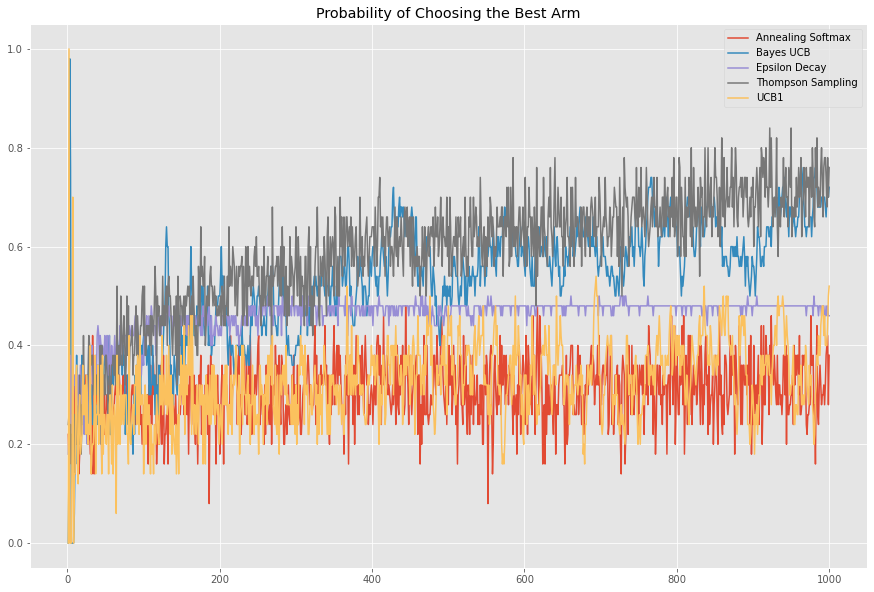

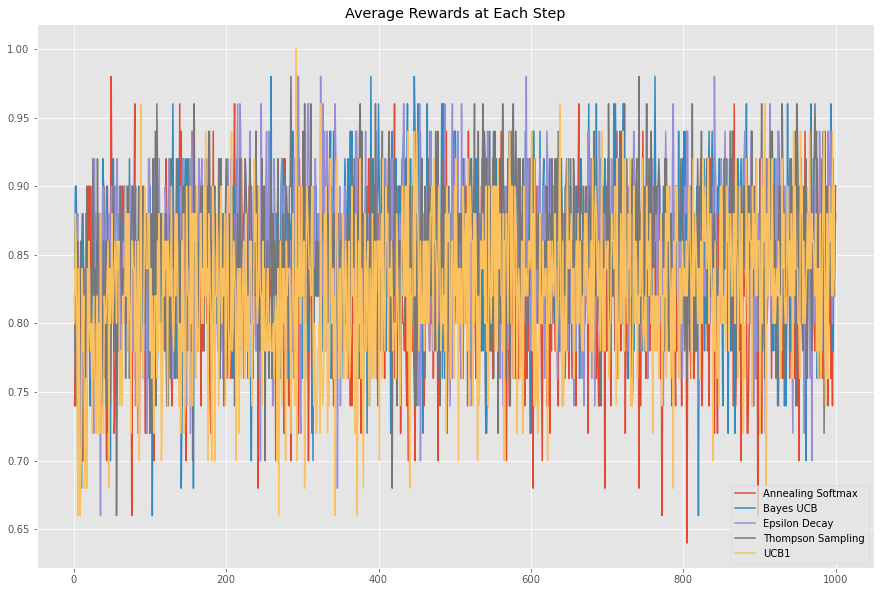

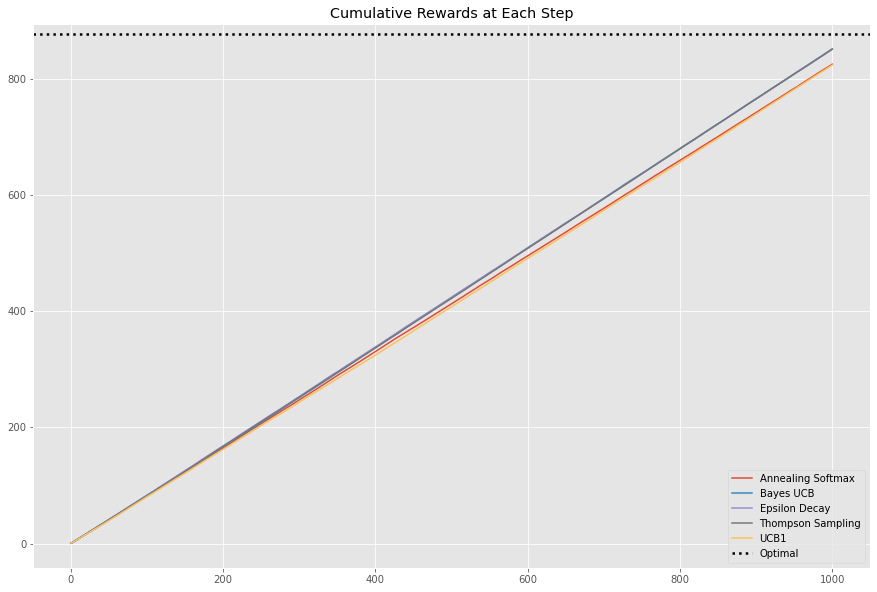

In [17]:
results_5['if_best_arm'] = np.where(results_5['chosen_arm']==optimal_movie, 1,0)

results_plot = results_5.groupby(['name','n_step'],as_index=False).aggregate({'if_best_arm':lambda x: x.sum()/(x.count()+0.0),'rewards':'mean', 'cumulative_rewards':'mean'})
plt.style.use('ggplot')

# plot for the best arm
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
for name in results_plot['name'].unique():
    ax.plot(results_plot[results_plot['name']==name]['n_step'],results_plot[results_plot['name']==name]['if_best_arm'], label=str(name))
plt.legend()
plt.title('Probability of Choosing the Best Arm')
# plt.savefig('best_arms'+suffix+'.png', dpi=300)

# plot for average rewards
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
for name in results_plot['name'].unique():
    ax.plot(results_plot[results_plot['name']==name]['n_step'],results_plot[results_plot['name']==name]['rewards'], label=str(name))
plt.legend()
plt.title('Average Rewards at Each Step')
# plt.savefig('avg_rewards'+suffix+'.png', dpi=300)

# plot for cumulative rewards
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
for name in results_plot['name'].unique(): 
    ax.plot(results_plot[results_plot['name']==name]['n_step'],results_plot[results_plot['name']==name]['cumulative_rewards'], label=str(name))

# plot optimal cumulative rewards
ax.axhline(y=optimal_cum_reward, color='k', linestyle=':', linewidth=2.5, label="Optimal")

plt.legend()
plt.title('Cumulative Rewards at Each Step')
# plt.savefig('cumulative_rewards'+suffix+'.png', dpi=300)

#### Regret Comparison

In [18]:
# Compare Algo to Optimal
algo_name = ["Epsilon Decay", "Annealing Softmax", "UCB1", "Bayes UCB", "Thompson Sampling"]
cum_reward_mean = []
regret_percent = []


for i in range(len(algo_name)):
    filtered = results_5[(results_5["name"] == algo_name[i]) & (results_5["n_step"]==1000)]
    mean = filtered["cumulative_rewards"].mean()
    cum_reward_mean.append(mean)
    regret = round((optimal_cum_reward - mean) / optimal_cum_reward,2)
    regret_percent.append(regret)
    
data = {
    'Algorithm Name': algo_name,
    'Cummulative Reward': cum_reward_mean,
    'Regret Percentage': regret_percent
}

regret_5 = pd.DataFrame(data)
regret_5

,Algorithm Name,Cummulative Reward,Regret Percentage
0,Epsilon Decay,851.10,0.03
1,Annealing Softmax,825.42,0.06
2,UCB1,824.00,0.06
3,Bayes UCB,851.42,0.03
4,Thompson Sampling,851.70,0.03


### 50 Movies

In [19]:
top_50_agg = df_by_count.iloc[:50,:]
top_50_agg.head()

,count,mean,like_count,like_prob
movie_id,,,,
2858,3428,4.317386,2853,0.832264
260,2991,4.453694,2622,0.876630
1196,2990,4.292977,2510,0.839465
1210,2883,4.022893,2127,0.737773
480,2672,3.763847,1730,0.647455


In [20]:
top_50_movies = top_50_agg.index.tolist()
df_top_50 = ratings[ratings["movie_id"].isin(top_50_movies)]
df_top_50.head()

,user_id,movie_id,rating,timestamp,like
0,1,1193,5,978300760,1
4,1,2355,5,978824291,1
5,1,1197,3,978302268,0
9,1,919,4,978301368,1
15,1,2791,4,978302188,1


#### Run Algorithms

In [21]:
n_arms = 50
mus = top_50_agg["like_prob"].tolist()
arms = list(map(lambda mu: BernoulliArm(mu), mus))

# initialization, arguments
N_SIMULATIONS = 50
N_STEPS = 1000

# Store final results
results_list = []

# Run Epsilon Decay
algo = EpsilonDecay([],[])
algo.initialize(n_arms)
results = pd.DataFrame(test_algorithm(algo, arms, N_SIMULATIONS, N_STEPS)).transpose()
results.columns=['n_sim','n_step','chosen_arm','rewards','cumulative_rewards']
results['name'] = 'Epsilon Decay'
results_list.append(results)


# Run Annealing Softmax
algo = AnnealingSoftmax([],[])
algo.initialize(n_arms)
results = pd.DataFrame(test_algorithm(algo, arms, N_SIMULATIONS, N_STEPS)).transpose()
results.columns=['n_sim','n_step','chosen_arm','rewards','cumulative_rewards']
results['name'] = 'Annealing Softmax'
results_list.append(results)

# Run UCB1
algo = UCB1([],[])
algo.initialize(n_arms)
results = pd.DataFrame(test_algorithm(algo, arms, N_SIMULATIONS, N_STEPS)).transpose()
results.columns=['n_sim','n_step','chosen_arm','rewards','cumulative_rewards']
results['name'] = 'UCB1'
results_list.append(results)

# Run Bayes UCB
algo = BayesUCB([],[])
algo.initialize(n_arms)
results = pd.DataFrame(test_algorithm(algo, arms, N_SIMULATIONS, N_STEPS)).transpose()
results.columns=['n_sim','n_step','chosen_arm','rewards','cumulative_rewards']
results['name'] = 'Bayes UCB'
results_list.append(results)

# Run Thompson Sampling
algo = ThompsonSampling([],[])
algo.initialize(n_arms)
results = pd.DataFrame(test_algorithm(algo, arms, N_SIMULATIONS, N_STEPS)).transpose()
results.columns=['n_sim','n_step','chosen_arm','rewards','cumulative_rewards']
results['name'] = 'Thompson Sampling'
results_list.append(results)

results_50 = pd.concat(results_list)
results_50.head()

,n_sim,n_step,chosen_arm,rewards,cumulative_rewards,name
0,1.0,1.0,22.0,1.0,1.0,Epsilon Decay
1,1.0,2.0,12.0,1.0,2.0,Epsilon Decay
2,1.0,3.0,43.0,1.0,3.0,Epsilon Decay
3,1.0,4.0,6.0,1.0,4.0,Epsilon Decay
4,1.0,5.0,18.0,1.0,5.0,Epsilon Decay


In [22]:
results_50.to_csv('output_movies50.csv',index=False)

#### Visualize Results

In [23]:
# Optimal Results
optimal_movie = np.argmax(top_50_agg["like_prob"].tolist())
optimal_cum_reward = top_50_agg["like_prob"].tolist()[optimal_movie]*1000

Text(0.5, 1.0, 'Cumulative Rewards at Each Step')

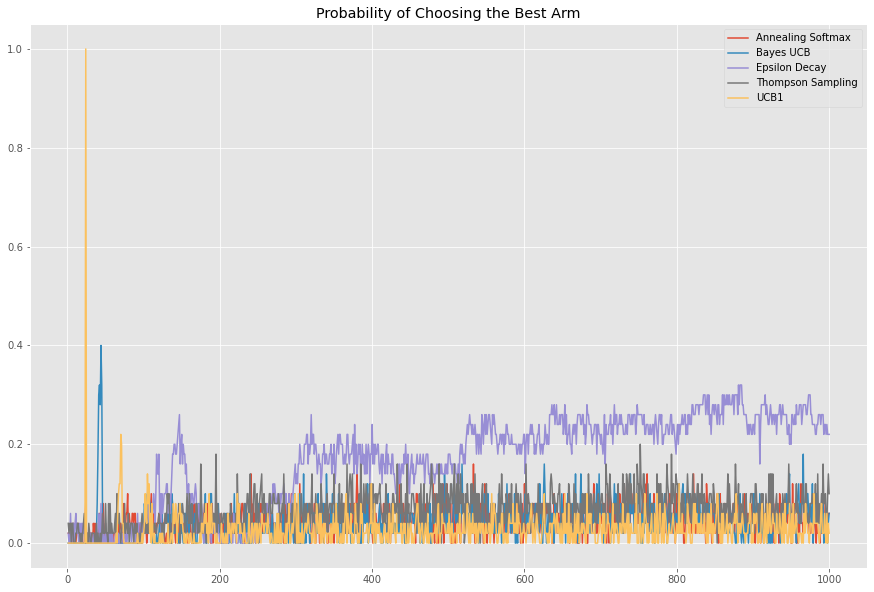

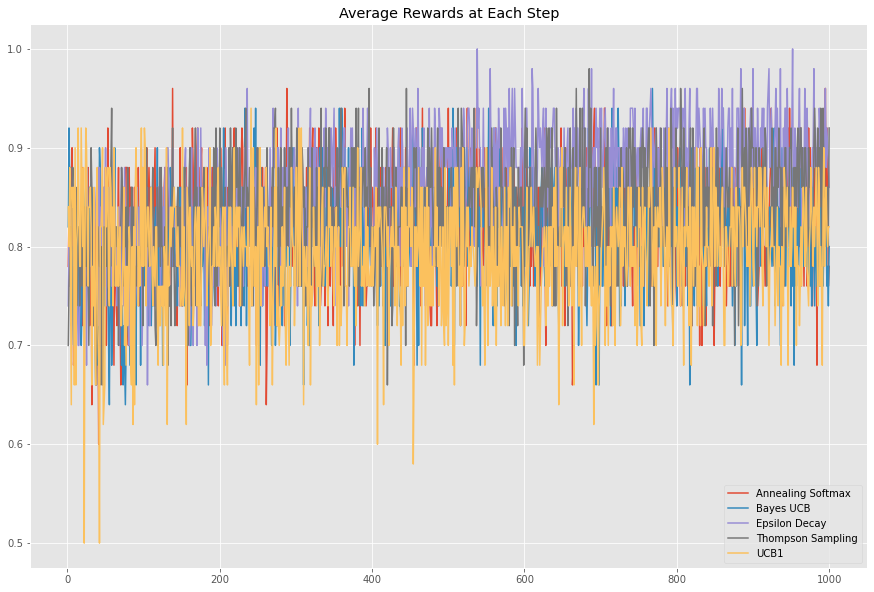

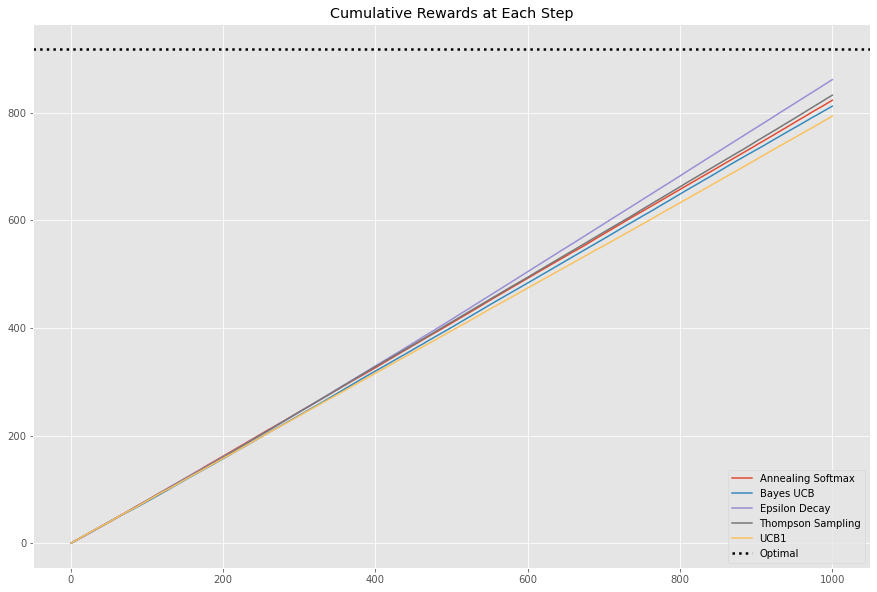

In [24]:
results_50['if_best_arm'] = np.where(results_50['chosen_arm']==optimal_movie, 1,0)

results_plot = results_50.groupby(['name','n_step'],as_index=False).aggregate({'if_best_arm':lambda x: x.sum()/(x.count()+0.0),'rewards':'mean', 'cumulative_rewards':'mean'})
plt.style.use('ggplot')

# plot for the best arm
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
for name in results_plot['name'].unique():
    ax.plot(results_plot[results_plot['name']==name]['n_step'],results_plot[results_plot['name']==name]['if_best_arm'], label=str(name))
plt.legend()
plt.title('Probability of Choosing the Best Arm')
# plt.savefig('best_arms'+suffix+'.png', dpi=300)

# plot for average rewards
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
for name in results_plot['name'].unique():
    ax.plot(results_plot[results_plot['name']==name]['n_step'],results_plot[results_plot['name']==name]['rewards'], label=str(name))
plt.legend()
plt.title('Average Rewards at Each Step')
# plt.savefig('avg_rewards'+suffix+'.png', dpi=300)

# plot for cumulative rewards
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
for name in results_plot['name'].unique(): 
    ax.plot(results_plot[results_plot['name']==name]['n_step'],results_plot[results_plot['name']==name]['cumulative_rewards'], label=str(name))

# plot optimal cumulative rewards
ax.axhline(y=optimal_cum_reward, color='k', linestyle=':', linewidth=2.5, label="Optimal")

plt.legend()
plt.title('Cumulative Rewards at Each Step')
# plt.savefig('cumulative_rewards'+suffix+'.png', dpi=300)

#### Regret Comparison

In [25]:
# Compare Algo to Optimal
algo_name = ["Epsilon Decay", "Annealing Softmax", "UCB1", "Bayes UCB", "Thompson Sampling"]
cum_reward_mean = []
regret_percent = []


for i in range(len(algo_name)):
    filtered = results_50[(results_50["name"] == algo_name[i]) & (results_50["n_step"]==1000)]
    mean = filtered["cumulative_rewards"].mean()
    cum_reward_mean.append(mean)
    regret = round((optimal_cum_reward - mean) / optimal_cum_reward,2)
    regret_percent.append(regret)
    
data = {
    'Algorithm Name': algo_name,
    'Cummulative Reward': cum_reward_mean,
    'Regret Percentage': regret_percent
}

regret_50 = pd.DataFrame(data)
regret_50

,Algorithm Name,Cummulative Reward,Regret Percentage
0,Epsilon Decay,861.60,0.06
1,Annealing Softmax,823.32,0.10
2,UCB1,793.84,0.14
3,Bayes UCB,812.26,0.12
4,Thompson Sampling,832.78,0.09
